In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

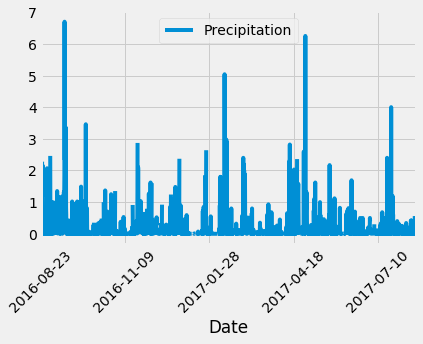

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
preYear=dt.date(2017,8,23)-dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
results=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=preYear).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(results,columns=["Date","Precipitation"])
df=df.set_index(df["Date"])
# Sort the dataframe by date
df=df.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=45)
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()


[(9)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
col=Measurement.station
amount=func.count(Measurement.station)
session.query(col,amount).group_by(col).order_by(amount.desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
results=session.query(Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
                      .filter(Measurement.station=="USC00519281").all()
pd.DataFrame(results,columns=["Station","Min Temp", "Max Temp", "Avg Temp"]).set_index("Station")

,Min Temp,Max Temp,Avg Temp
Station,,,
USC00519281,54.0,85.0,71.663781


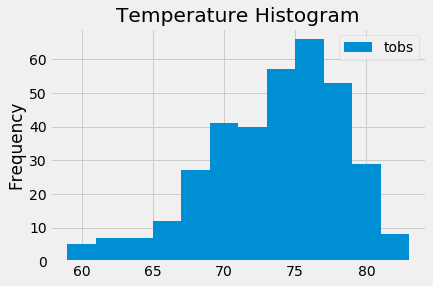

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempHist=session.query(Measurement.tobs).filter(Measurement.station=="USC00519281")\
                       .filter(Measurement.date>=preYear).all()
pd.DataFrame(tempHist).hist(bins=12,label="tobs")
plt.ylabel("Frequency")
plt.title("Temperature Histogram")
plt.legend()
plt.savefig("Temp_Histogram.png")
plt.show()


In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Let's choose the date range 4/10/2014-4/22/2014. That seems like a good amount of time for a trip to Hawaii!
last_date = session.query(Measurement.date).\
            order_by(Measurement.date.desc()).first()

trip_start_date = '2014-04-10'
trip_end_date = '2014-04-22'

last_year_date = (dt.datetime.strptime(last_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

def get_last_year_dates(start_date, end_date):
    """Calculates last year's start and end dates given the input start and end dates.
       This assumes no leap year (yet). 
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        last_year_start_date (string): A date string in the format %Y-%m-%d 365 days earlier than start_date
        last_year_end_date (string): A date string in the format %Y-%m-%d 365 days earlier than end_date
    """
    
    last_year_start_date = (dt.datetime.strptime(trip_start_date,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
    last_year_end_date = (dt.datetime.strptime(trip_end_date,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
    return last_year_start_date, last_year_end_date

last_start_date, last_end_date = get_last_year_dates(trip_start_date, trip_end_date)

tmin, tavg, tmax = calc_temps(last_start_date,last_end_date)[0]
print(tmin, tavg, tmax)

63.0 72.47524752475248 81.0


No handles with labels found to put in legend.


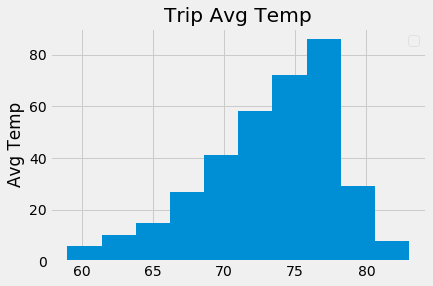

In [19]:
tempBar=session.query(Measurement.tobs).filter(Measurement.station=="USC00519281")\
                       .filter(Measurement.date>=preYear).all()
pd.DataFrame(tempBar).hist()
plt.ylabel("Avg Temp")
plt.title("Trip Avg Temp")
plt.legend()
plt.savefig("Temp_Bar.png")
plt.show()

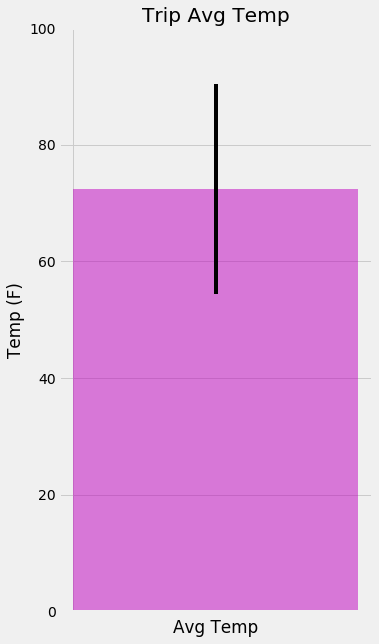

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(5,10));
plt.bar(x="",height=tavg,yerr=tmax-tmin,color='m',alpha=.5,align='edge');
plt.ylim(0,100);
plt.xlabel("Avg Temp")
plt.ylabel("Temp (F)");
plt.title("Trip Avg Temp");

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

query_columns = [Station.station, Station.name, func.sum(Measurement.tobs), Station.latitude, Station.longitude, Station.elevation]

last_year_data =    session.query(*query_columns).\
                    group_by(Measurement.station).\
                    outerjoin(Station, Measurement.station==Station.station).\
                    filter(Measurement.date >= last_start_date).filter(Measurement.date <= last_end_date).\
                    order_by(func.sum(Measurement.tobs).desc()).all()
last_year_data

[('USC00519397', 'WAIKIKI 717.2, HI US', 966.0, 21.2716, -157.8168, 3.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  948.0,
  21.33556,
  -157.71139,
  19.5),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  926.0,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 924.0, 21.4234, -157.8015, 14.6),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  922.0,
  21.3152,
  -157.9992,
  0.9),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  920.0,
  21.3331,
  -157.8025,
  152.4),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  905.0,
  21.5213,
  -157.8374,
  7.0),
 ('USC00517948', 'PEARL CITY, HI US', 669.0, 21.3934, -157.9751, 11.9),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  140.0,
  21.4992,
  -158.0111,
  306.6)]

In [28]:
pd.DataFrame(last_year_data,
             columns=["Station","Station_Name", "Total_Rainfall", "Latitude", "Longitude", "Elevation"]
            ).sort_values("Total_Rainfall",ascending=False)

,Station,Station_Name,Total_Rainfall,Latitude,Longitude,Elevation
0,USC00519397,"WAIKIKI 717.2, HI US",966.0,21.27160,-157.81680,3.0
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",948.0,21.33556,-157.71139,19.5
2,USC00519281,"WAIHEE 837.5, HI US",926.0,21.45167,-157.84889,32.9
3,USC00513117,"KANEOHE 838.1, HI US",924.0,21.42340,-157.80150,14.6
4,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",922.0,21.31520,-157.99920,0.9
5,USC00516128,"MANOA LYON ARBO 785.2, HI US",920.0,21.33310,-157.80250,152.4
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",905.0,21.52130,-157.83740,7.0
7,USC00517948,"PEARL CITY, HI US",669.0,21.39340,-157.97510,11.9
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",140.0,21.49920,-158.01110,306.6


## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
print(f"The trip dates are {trip_start_date} to {trip_end_date}")

# Set the start and end date of the trip
s_date = dt.datetime.strptime(trip_start_date,'%Y-%m-%d')
e_date = dt.datetime.strptime(trip_end_date,'%Y-%m-%d') 
delta = e_date - s_date
normals = []

for i in range(delta.days + 1):
    day = s_date + dt.timedelta(days=i)
    # Strip off the year and save a list of %m-%d strings
    month_day = dt.datetime.strftime(day,'%m-%d')
    normals.append(month_day)
    
normals

# Loop through the list of %m-%d strings and calculate the normals for each date
normal_list = []
for day in normals:
    normal_list.append(daily_normals(day)[0])
    
normal_list

The trip dates are 2014-04-10 to 2014-04-22


[(64.0, 71.40350877192982, 79.0),
 (65.0, 72.49180327868852, 82.0),
 (65.0, 72.22413793103448, 80.0),
 (64.0, 71.52542372881356, 79.0),
 (65.0, 72.75, 81.0),
 (61.0, 71.79310344827586, 79.0),
 (62.0, 71.55357142857143, 81.0),
 (65.0, 71.93103448275862, 77.0),
 (67.0, 72.49152542372882, 77.0),
 (65.0, 72.42105263157895, 83.0),
 (64.0, 72.73684210526316, 80.0),
 (66.0, 72.32142857142857, 78.0),
 (65.0, 72.92727272727272, 84.0)]

In [33]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normal_list,columns=["tmin","tavg","tmax"],index=[normals])
normals_df.index = normals_df.index.get_level_values(0)
normals_df

,tmin,tavg,tmax
04-10,64.0,71.403509,79.0
04-11,65.0,72.491803,82.0
04-12,65.0,72.224138,80.0
04-13,64.0,71.525424,79.0
04-14,65.0,72.750000,81.0
04-15,61.0,71.793103,79.0
04-16,62.0,71.553571,81.0
04-17,65.0,71.931034,77.0
04-18,67.0,72.491525,77.0
04-19,65.0,72.421053,83.0


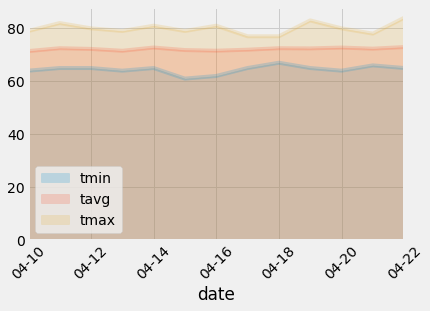

In [34]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind="area",stacked=False,rot=45,alpha=.2);
plt.xlabel("date");